# Compare today's matter power spectra for PM, BullFrog 🐸 and COLA

Mayeul Aubin, Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

Plot today's matter power spectra for PM, BullFrog 🐸 and COLA, given pre-computed simulations.

In [12]:
from pathlib import Path
import pickle
import numpy as np
from pysbmy.fft import read_FourierGrid, FourierGrid
from pysbmy.correlations import get_autocorrelation

from tools import read_field
from plot_utils import *

## Set up the environment

In [13]:
# run_id = "N512z24"
# run_id = "N384z24"
# run_id = "N768z24"
run_id = "N1536z24"

workdir = (
    f"/home/aubin/data/BullFrog/comparison_article/params/{run_id}/"
)
simdir = f"/home/aubin/data/BullFrog/comparison_article/sims/{run_id}/"

outdir = simdir + "plots/"

## Load data and plot

In [14]:
Path(outdir).mkdir(parents=True, exist_ok=True)

with open(workdir + "params.pkl", "rb") as f:
    params = pickle.load(f)

N = params["N"]
L = params["L"]
nsteps_pm_list = params["nsteps_pm"]
nsteps_cola_list = params["nsteps_cola"]
nsteps_bullfrog_list = params["nsteps_bullfrog"]
print(N, L, nsteps_pm_list, nsteps_cola_list, nsteps_bullfrog_list)

### Plot the evolved dark matter density fields

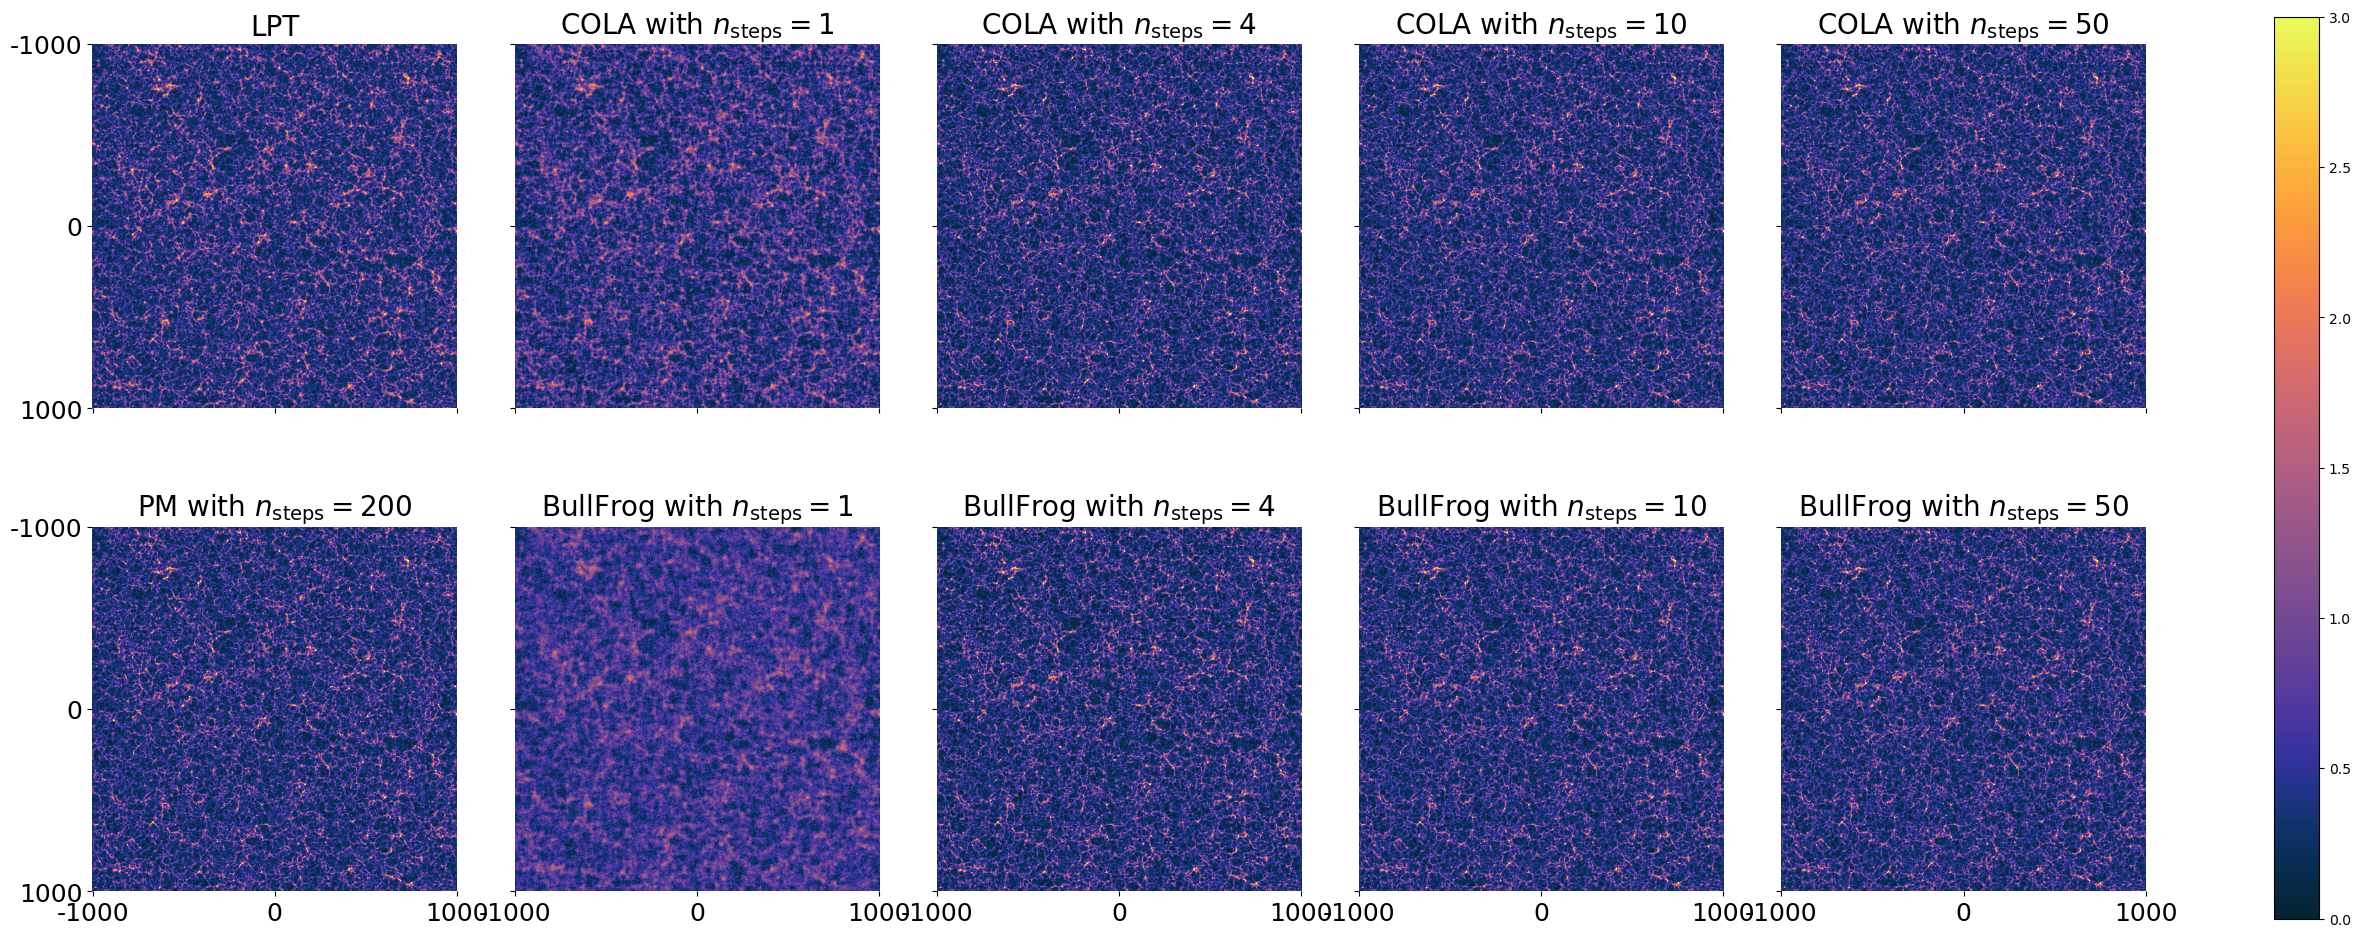

In [15]:
slice_ijk = (N // 2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

vmin=0
vmax=3

all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

ncols = len(all_nsteps) + 1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols+2, 5 * nrows), sharex=True, sharey=True)
axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
axs[0, 0].set_title("LPT", fontsize=fs_titles)
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
        axs[0, i + 1].imshow(np.log(2 + DELTA_COLA), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
        axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
    if nsteps in nsteps_bullfrog_list:
        DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[
            slice_ijk
        ]
        im = axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
        axs[1, i + 1].set_title(
            f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles
        )
for ax in axs.flatten():
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
for ax in axs[:, 0]:
    ax.set_yticks([0, N // 2, N])
    ax.set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
for ax in axs[1, :]:
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
for i in range(nrows):
    for j in range(ncols):
        if axs[i, j].get_title() == "":
            axs[i, j].axis("off")

plt.tight_layout()
fig.colorbar(im,ax=axs)

# fig.savefig(outdir + "density_fields.png", bbox_inches="tight", transparent=True, dpi=300)
# fig.savefig(outdir + "density_fields.pdf", bbox_inches="tight", transparent=True)
plt.show()

### Compute and plot the power spectra of the evolved dark matter fields

In [16]:
Pinit = 100
trim_threshold = 1  # Min number of modes required per bin for the summaries
# logkmin = np.log10(4 * np.pi / (np.sqrt(3) * L))
logkmin = np.log10(3e-3)
kmax = np.pi * N / L
Pbins_left_bnds = np.logspace(logkmin, np.log10(kmax), Pinit + 1, dtype=np.float32)
Pbins_left_bnds = Pbins_left_bnds[:-1]

G = FourierGrid(
            L,
            L,
            L,
            N,
            N,
            N,
            k_modes=Pbins_left_bnds,
            kmax=kmax,
            trim_bins=True,
            trim_threshold=trim_threshold,
        )

In [17]:
# G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes
print(k.shape)
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, False)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

Pk_PM_list = []
Sk_PM_list = []
for nsteps in nsteps_pm_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
    Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
    Sk_PM = np.sqrt(Vk_PM)
    Pk_PM_list.append(Pk_PM)
    Sk_PM_list.append(Sk_PM)

Pk_ref = Pk_PM_list[-1]

Pk_COLA_list = []
Sk_COLA_list = []
for nsteps in nsteps_cola_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
    Sk_COLA = np.sqrt(Vk_COLA)
    Pk_COLA_list.append(Pk_COLA)
    Sk_COLA_list.append(Sk_COLA)

Pk_BULLFROG_list = []
Sk_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
    Pk_BULLFROG, Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_BULLFROG, Vk_BULLFROG = Pk_BULLFROG[1:], Vk_BULLFROG[1:]
    Sk_BULLFROG = np.sqrt(Vk_BULLFROG)
    Pk_BULLFROG_list.append(Pk_BULLFROG)
    Sk_BULLFROG_list.append(Sk_BULLFROG)

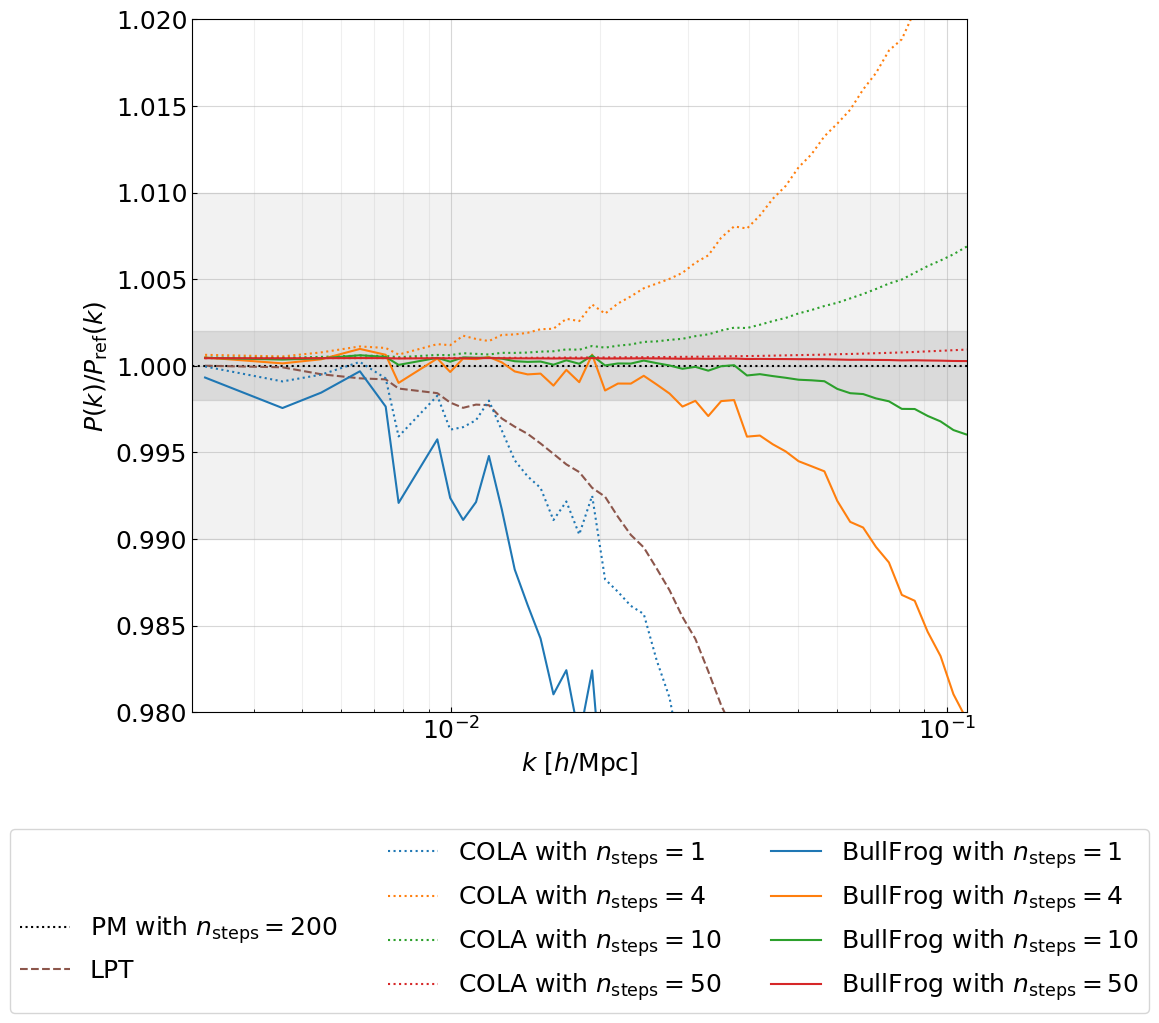

In [18]:
common_nsteps = sorted(set(nsteps_cola_list).intersection(nsteps_bullfrog_list))
min_nsteps = 0  # 0, 1, 5
# filter out first spectra:
common_nsteps = [nsteps for nsteps in common_nsteps if nsteps > min_nsteps]
nlabrows = len(common_nsteps)

fig, ax = plt.subplots(figsize=(10, 9))
ax.set_xscale("log")
k = G.k_modes[1:]
# ax.set_xlim([k.min(), k.max()])
ax.set_xlim([3e-3, 1.1e-1])
bnd1 = 0.002  # to be adjusted depending on the setup
bnd2 = 0.01  # to be adjusted depending on the setup

label_ref = f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$"
line1 = ax.plot([1e-3, 1e1], [1, 1], color="black", linestyle=":", label=label_ref)
line2 = ax.plot(
    k, Pk_LPT / Pk_ref, label="LPT", color=cols[len(common_nsteps) + 1], linestyle="--"
)
# line3 = ax.plot(k, Pk_INI / Pk_ref, label="ICs", color=cols[len(common_nsteps)], linestyle="--")
line3 = None

# for i, nsteps in enumerate(nsteps_pm_list[:-1]):
#     ax.plot(
#         k,
#         Pk_PM_list[i] / Pk_ref,
#         label=f"PM with $n_\\mathrm{{steps}}={nsteps}$",
#         linestyle="--",
#         color=cols[i],
#     )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_COLA_list[i] / Pk_ref,
        label=f"COLA with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle=":",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_BULLFROG_list[i] / Pk_ref,
        label=f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="-",
        color=cols[i],
    )

ax.axhspan(1 - bnd1, 1 + bnd1, color="grey", alpha=0.2)
ax.axhspan(1 - bnd2, 1 + bnd2, color="grey", alpha=0.1)

# ax.grid(alpha=0.3)
# for i in range(1, len(k)):
#     ax.axvline(k[i], color="black", linestyle=":", linewidth=1, alpha=0.1)
# ax.yaxis.set_major_locator(plt.MaxNLocator(6))
# ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

ax.set_ylim([0.98, 1.02])  # to be adjusted depending on the setup
ax.set_yticks([0.98, 0.985, 0.99, 0.995, 1, 1.005, 1.01, 1.015, 1.02])

ax.grid(which="major",alpha=0.5)
ax.grid(which="minor",alpha=0.2)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)
nleft = 2 if line3 is None else 3
empty_patches = [mpatches.Patch(color="none", label="") for _ in range(max(0, nlabrows - nleft))]
handles, labels = plt.gca().get_legend_handles_labels()
handles = [*empty_patches, *handles]
labels = [""] * len(empty_patches) + labels

plt.legend(
    handles,
    labels,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.15),
    fontsize=fs,
)

# fig.savefig(outdir + "Pk.png", bbox_inches="tight", transparent=True, dpi=300)
# fig.savefig(outdir + "Pk.pdf", bbox_inches="tight", transparent=True)
plt.show()

In [19]:
## computes KL divergence
def KL_divergence(DELTA_ref, DELTA):
    # convert deltas into densities
    P = np.clip((1 + np.array(DELTA_ref.data)), 1e-3, 1e12)
    Q = np.clip((1 + np.array(DELTA.data)), 1e-3, 1e12)
    assert (
        P.shape == Q.shape
    ), f"Different shapes of density fields: {P.shape} and {Q.shape}"

    sumP = np.sum(P)
    sumQ = np.sum(Q)
    return np.sum(P * np.log(P / Q)) / sumP - np.log(sumP / sumQ)

In [20]:
DELTA_REF = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5")
KL_PM_list = []
for nsteps in nsteps_pm_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
    KL_PM_list.append(KL_divergence(DELTA_REF, DELTA))

KL_PM_list = np.array(KL_PM_list)

KL_COLA_list = []
for nsteps in nsteps_cola_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    KL_COLA_list.append(KL_divergence(DELTA_REF, DELTA))

KL_COLA_list = np.array(KL_COLA_list)

KL_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
    KL_BULLFROG_list.append(KL_divergence(DELTA_REF, DELTA))


KL_BULLFROG_list = np.array(KL_BULLFROG_list)

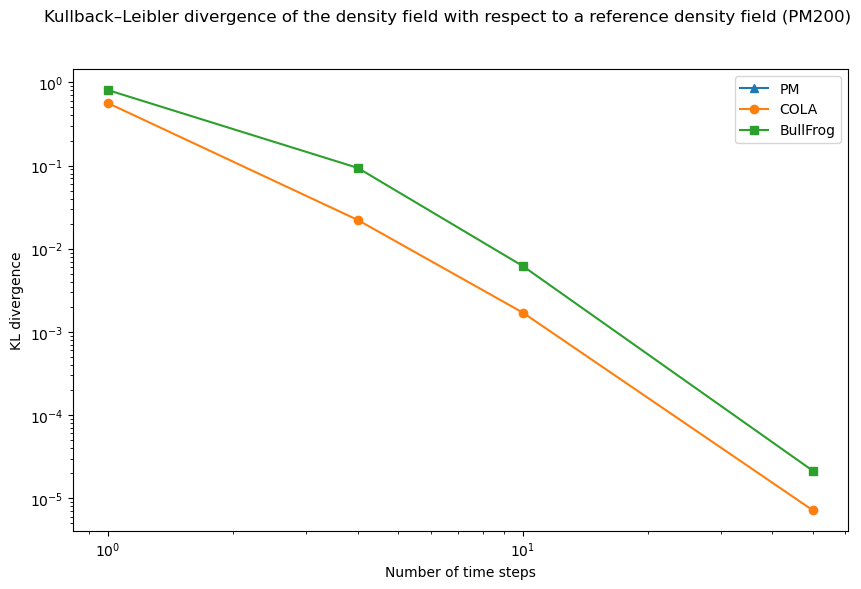

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    nsteps_pm_list[:-1],
    KL_PM_list[:-1],
    label="PM",
    marker="^",
)
ax.plot(
    nsteps_cola_list,
    KL_COLA_list,
    label="COLA",
    marker="o",
)
ax.plot(
    nsteps_bullfrog_list,
    KL_BULLFROG_list,
    label="BullFrog",
    marker="s",
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Number of time steps")
ax.set_ylabel("KL divergence")
fig.suptitle(
    "Kullback–Leibler divergence of the density field with respect to a reference density field (PM200)"
);